In [1]:
import numpy as np
import torch as th

#!pip install forgi
import forgi
import forgi.graph.bulge_graph as fgb
import forgi.threedee as ft
import forgi.threedee.model.coarse_grain as ftmc


import matplotlib.pyplot as plt
import networkx as nx
import os

#install PyG in google colab

#!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu111.html

In [2]:
print(th.__version__)
print(th.cuda.is_available())

#!tar -xf data.tar.xz

1.10.2
True


TODO:
*  figure out how PyG returns graph level predictions (shape of prediction doesnt match shape of labels per batch)

In [3]:
#Graph Building
from torch_geometric.data import Data

#load coarse grain file
def load_cg_file(file): 
    cg = ftmc.CoarseGrainRNA.from_bg_file(file) 
    c_dict = dict(cg.coords)
    t_dict = dict(cg.twists)
    coord_dict = {}
    twist_dict = {}
    for e in c_dict:
        a = th.from_numpy(c_dict[e][0])
        b = th.from_numpy(c_dict[e][1])
        coord_dict[e] = a, b
        if e in t_dict:
            c = th.from_numpy(t_dict[e][0])
            d = th.from_numpy(t_dict[e][1])
            twist_dict[e] = c, d
        
    # Get elements and neighbours:
    connections = {}
    for elem in cg.sorted_element_iterator():
        neighbours = cg.connections(elem)
        if elem not in connections:
            connections[elem] = cg.connections(elem)
    return coord_dict, twist_dict, connections

def build_graph(coord_dict, twist_dict, connections, label):
    #dictionary to convert type
    type_transl = {
        "h": [1, 0, 0, 0, 0, 0],
        "i": [0, 1, 0, 0, 0, 0],
        "m": [0, 0, 1, 0, 0, 0],
        "s": [0, 0, 0, 1, 0, 0],
        "f": [0, 0, 0, 0, 1, 0],
        "t": [0, 0, 0, 0, 0, 1]
    } 

    #encode nodes numerically for edge index
    num_graph = {}
    for num, n in enumerate(sorted(connections)):
        num_graph[n] = num


    #build graph and edges
    u = []
    v = []
    for node in connections:
        for c in connections[node]:
            u.append(num_graph[node])
            v.append(num_graph[c])
    
    edge_index = th.tensor([u, v], dtype=th.long)

    x = []
    for elem in sorted(connections):
        a = np.array(type_transl[elem[0]])
        b = np.concatenate(coord_dict[elem])
        if elem in twist_dict:
            c = np.concatenate(twist_dict[elem]) 
        else:
            c = np.zeros(6)
        z = np.append(a, [b, c])
        x.append(z)
    x = np.array(x)
    x = th.tensor(x, dtype=th.float32)

    graph = Data(x=x, edge_indexndex=edge_index, y=label)

    return graph


In [4]:
#create a dict with name and rmsd as labels
def get_rmsd_dict(rmsd_list):
    rmsd_dict = {}
    with open(rmsd_list, "r") as fh:
        for line in fh.readlines():
            name, rmsd = (line.rstrip()).split("\t")
            rmsd_dict[name] = float(rmsd)
    return rmsd_dict


In [41]:
#Graph Dataset Class
from torch_geometric.data import InMemoryDataset

class CGDataset(InMemoryDataset):
    def __init__(self, root, rmsd_list, transform=None, pre_transform=None):
        self.file_path = root
        self.rmsd_list = rmsd_list
        super(CGDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = th.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return [f for f in os.listdir(self.file_path) if os.path.isfile(os.path.join(self.file_path, f))]
    
    @property
    def processed_file_names(self):
        return ['data.pt']

    def process(self):
        self.graphs = []
        rmsd_dict = get_rmsd_dict(self.rmsd_list)
        
        files = []

        for file in self.raw_file_names:
            if file.endswith(".cg") and file in rmsd_dict.keys():
                files.append(file)

        for struc in files:
            coord_dict, twist_dict, connections = load_cg_file(os.path.join(self.file_path, struc))
            graph = build_graph(coord_dict, twist_dict, connections, rmsd_dict[struc])
            self.graphs.append(graph)

        if self.pre_filter is not None:
            self.graphs = [data for data in self.graphs if self.pre_filter(data)]

        if self.pre_transform is not None:
            self.graphs = [self.pre_transform(data) for data in self.graphs]

        data, slices = self.collate(self.graphs)
        th.save((data, slices), self.processed_paths[0])
        
    '''
    def get(self, idx):
        data = torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
        return data

    def len(self):
        return len(self.graphs)
    '''


In [28]:
#Model

import torch.nn.functional as F
import torch_geometric.nn as tgnn

#Coarse Grain RNA Classifier Model
class CG_Classifier(th.nn.Module):
    def __init__(self):
        self.c = 0
        super(CG_Classifier, self).__init__()
        
        self.conv1 = tgnn.TAGConv(18, 200, K=2)
        self.conv2 = tgnn.TAGConv(200, 150, K=2)
        self.conv3 = tgnn.TAGConv(150, 100, K=2)
        self.conv4 = tgnn.TAGConv(100, 50, K=2)
        self.conv5 = tgnn.TAGConv(50, 25, K=2)
        
        self.sage_conv1 = tgnn.SAGEConv(25, 60)
        self.sage_conv2 = tgnn.SAGEConv(60, 50)
        self.sage_conv3 = tgnn.SAGEConv(50, 40)
        self.sage_conv4 = tgnn.SAGEConv(40, 30)
        self.sage_conv5 = tgnn.SAGEConv(30, 20)
        
        #self.readout = tgnn.SAGPooling(20)
        
        self.classify = th.nn.Sequential(
            th.nn.Linear(20, 512),
            th.nn.ELU(),
            th.nn.Linear(512, 512),
            th.nn.ELU(),
            th.nn.Linear(512, 512),
            th.nn.ELU(),
            th.nn.Linear(512, 512),
            th.nn.ELU(),
            th.nn.Linear(512, 1)
        )
        
    def forward(self, x, edge_index, batch):

        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        x = F.elu(x)
        x = self.conv3(x, edge_index)
        x = F.elu(x)
        x = self.conv4(x, edge_index)
        x = F.elu(x)
        x = self.conv5(x, edge_index)

        x = self.sage_conv1(x, edge_index)
        x = F.elu(x)
        x = self.sage_conv2(x, edge_index)
        x = F.elu(x)
        x = self.sage_conv3(x, edge_index)
        x = F.elu(x)
        x = self.sage_conv4(x, edge_index)
        x = F.elu(x)
        x = self.sage_conv5(x, edge_index)
        x = F.elu(x)

        x = tgnn.global_mean_pool(x, batch) #self.readout(x, edge_index)
        
        return self.classify(x)

In [42]:
#Training Set
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T

training_dir = "./data/train_set"
rmsd_list = "./data/truncated_train_rmsd.txt"

training_dataset = CGDataset(training_dir, rmsd_list)


Processing...
Done!


In [43]:
#Validation Set
val_dir = "./data/val_set"
val_rmsd = "./data/val_rmsd_list.txt"

val_dataset = CGDataset(val_dir, val_rmsd)


In [9]:
print(training_dataset.data.x.shape)
print(training_dataset.data.is_undirected())
print(len(training_dataset))
print(training_dataset[0].num_nodes)
print(training_dataset[0].y)
print(training_dataset[0].num_edges)

torch.Size([15382, 18])
True
1083
12
tensor([20.8720])
24


Epoch 0: Training loss 11.1832, Validation loss 14.0986, learning rate: 0.00500
Epoch 5: Training loss 5.1013, Validation loss 28.2295, learning rate: 0.00496
Epoch 10: Training loss 4.7365, Validation loss 18.2571, learning rate: 0.00485
Epoch 15: Training loss 3.9838, Validation loss 24.4147, learning rate: 0.00469
Epoch 20: Training loss 3.6299, Validation loss 19.0134, learning rate: 0.00448
Epoch 25: Training loss 3.3744, Validation loss 22.2387, learning rate: 0.00421
Epoch 30: Training loss 3.0899, Validation loss 17.4778, learning rate: 0.00391
Epoch 35: Training loss 3.1396, Validation loss 16.2432, learning rate: 0.00356
Epoch 40: Training loss 2.9440, Validation loss 21.3169, learning rate: 0.00320
Epoch 45: Training loss 2.6175, Validation loss 18.7154, learning rate: 0.00281
Epoch 50: Training loss 2.3517, Validation loss 16.6128, learning rate: 0.00242
Epoch 55: Training loss 2.2523, Validation loss 17.6497, learning rate: 0.00203
Epoch 60: Training loss 1.7634, Validatio

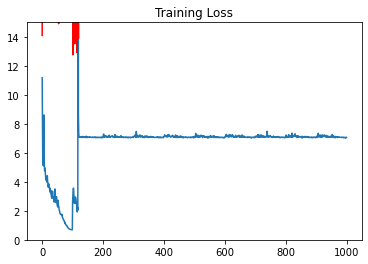

In [54]:
#Training
import time
start = time.perf_counter()

device = th.device('cuda' if th.cuda.is_available() else 'cpu')
model = CG_Classifier().to(device)

b_size = 32
train_dataloader = DataLoader(training_dataset, batch_size=b_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=b_size)

opt = th.optim.Adam(model.parameters(), lr=5e-3)
scheduler = th.optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=100)
model.train()

epochs = 1000

#training setup
epoch_losses = []
val_losses = []
learning_rates = []
for epoch in range(epochs):
    epoch_loss = 0
    learning_rates.append(scheduler.get_last_lr()[0])
    for iter, data in enumerate(train_dataloader):
        data = data.to(device)
        opt.zero_grad()
        pred = model(data.x, data.edge_index, data.batch)
        loss = F.smooth_l1_loss(th.reshape(pred, (-1,)), data.y, reduction='mean')
        loss.backward()
        opt.step()
        epoch_loss += loss.detach().item()

    #apply lr changes according to scheme
    scheduler.step()

    epoch_loss /= (iter + 1)
    epoch_losses.append(epoch_loss)

    #val setup
    val_loss = 0
    for i, v_data in enumerate(val_dataloader):
        v_data = v_data.to(device)
        val_pred = model(v_data.x, v_data.edge_index, v_data.batch)
        v_loss = F.smooth_l1_loss(val_pred, v_data.y, reduction='mean')
        val_loss += v_loss.detach().item()

    val_loss /= (i + 1)
    
    val_losses.append(val_loss)
    
    
    th.save(model.state_dict(), "model_data_pyg/model_epoch" + str(epoch) + ".pth")
    
    if epoch % 5 == 0:
        print("Epoch {}: Training loss {:.4f}, Validation loss {:.4f}, learning rate: {:.5f}".format(epoch, epoch_loss, val_loss, scheduler.get_last_lr()[0]))
        
end = time.perf_counter()

print("Training took {:.2f} hours".format((end - start)/60/60))
print("Minimum Training Loss {:.4f} in epoch {}".format(min(epoch_losses), epoch_losses.index(min(epoch_losses))))
print("Minimum Validation Loss {:.4f} in epoch {}".format(min(val_losses), val_losses.index(min(val_losses))))

#plot the training run
plt.plot(epoch_losses)
plt.plot(val_losses, 'r')
plt.title("Training Loss")
plt.ylim(ymax=15, ymin=0)
plt.draw()

In [ ]:
#store training run data

file = "pyg_loss_data_2022-02-15.txt"

with open("data/" + file, "w") as fh:
    fh.write(str(epoch_losses) + "\n")
    fh.write(str(val_losses) + "\n")
    fh.write(str(learning_rates))

In [ ]:
#get training run data

file = "pyg_loss_data_2022-02-15.txt"

file_lines = []
with open("data/" + file, "r") as fh:
    for line in fh.readlines():
        file_lines.append(line.rstrip("]\n").lstrip("[").split(","))

epoch_losses = [float(a) for a in file_lines[0]]
val_losses = [float(b) for b in file_lines[1]]
learning_rates = [float(c) for c in file_lines[2]]

print("Minimum Training Loss {:.4f} in epoch {}".format(min(epoch_losses), epoch_losses.index(min(epoch_losses))))
print("Minimum Validation Loss {:.4f} in epoch {}".format(min(val_losses), val_losses.index(min(val_losses))))


Minimum Training Loss 0.0002 in epoch 999
Minimum Validation Loss 13.1550 in epoch 607


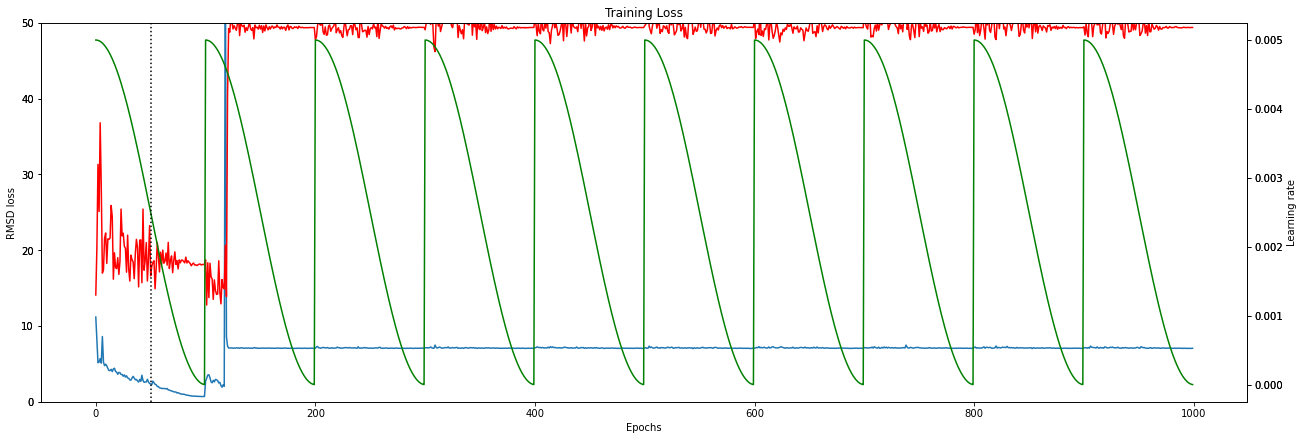

In [56]:
#plot the training run
fig, ax1 = plt.subplots(layout='constrained', figsize=(18, 6))
ax1.secondary_yaxis('left')
ax1.plot(epoch_losses)
ax1.plot(val_losses, 'r')
ax2 = ax1.twinx()
ax2.secondary_yaxis('right')
ax2.plot(learning_rates, 'g')
plt.title("Training Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("RMSD loss")
ax2.set_ylabel("Learning rate")
ax1.set_ybound(lower=0, upper=50)
plt.axvline(x = 50, c = 'black', ls = ':')
#plt.axvline(x = 96, c = 'black', ls = ':')
#plt.axvline(x = 145, c = 'black', ls = ':')
#plt.axvline(x = 190, c = 'black', ls = ':')
#plt.axvline(x = 250, c = 'black', ls = ':')
#plt.axvline(x = 321, c = 'black', ls = ':')
#plt.axvline(x = 404, c = 'black', ls = ':')
plt.draw()

In [52]:
#Test Data
test_dir = "./data/test_set"
test_rmsd = "./data/test_rmsd_list.txt"

test_dataset = CGDataset(test_dir, test_rmsd)

test_dataloader = DataLoader(test_dataset)

Processing...
Done!


In [53]:
#5S rRNA and tRNA Test Data (previous training data)
st_test_dir = "./data/old_training_set"
st_test_rmsd = "./data/old_train_rmsd_list.txt"

st_test_dataset = CGDataset(st_test_dir, st_test_rmsd)

st_test_dataloader = DataLoader(st_test_dataset)

Normal Test Set
tensor([26.2070], device='cuda:0') tensor([26.1803], device='cuda:0', grad_fn=<ReshapeAliasBackward0>) 0.026716232299804688
tensor([0.], device='cuda:0') tensor([31.0555], device='cuda:0', grad_fn=<ReshapeAliasBackward0>) 31.055545806884766
Mean Test loss: 	 11.5677
Std. Dev. of Test loss:  8.1463
Min loss: 		 0.0267
First Quantile: 	 4.1920
Median: 		 10.8107
Third Quantile: 	 16.3754
Max Loss: 		 31.0555


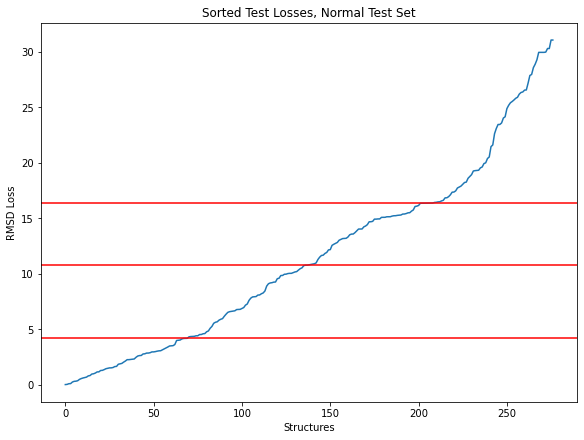

5S rRNA and tRNA Test Set
tensor([18.3310], device='cuda:0') tensor([18.3309], device='cuda:0', grad_fn=<ReshapeAliasBackward0>) 0.0001201629638671875
tensor([0.], device='cuda:0') tensor([91.0366], device='cuda:0', grad_fn=<ReshapeAliasBackward0>) 91.0365982055664
Mean Test loss: 	 6.5264
Std. Dev. of Test loss:  7.0914
Min loss: 		 0.0001
First Quantile: 	 1.7443
Median: 		 4.2845
Third Quantile: 	 8.5369
Max Loss: 		 91.0366


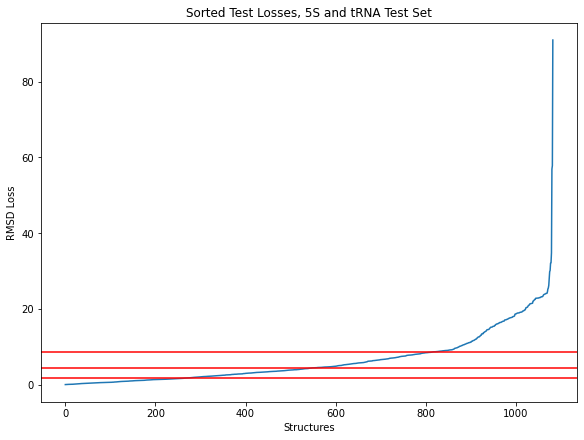

In [65]:
#Test
import math

if "model" not in globals():
    model = CG_Classifier(num_features=3)

model.to(device)

model.load_state_dict(th.load("model_data_pyg/model_epoch101.pth"))

model.eval()

for loader in [test_dataloader, st_test_dataloader]:
    max_label = 0
    max_loss = 0
    max_pred = 0
    min_label = math.inf
    min_loss = math.inf
    min_pred = math.inf
    test_losses = []
    for test_graph in loader:
        test_graph = test_graph.to(device)
        test_pred = model(test_graph.x, test_graph.edge_index, test_graph.batch)
        test_loss = F.l1_loss(test_pred, test_graph.y).item() #smooth_l1_loss
        test_losses.append(test_loss)
        if test_loss > max_loss:
            max_loss = test_loss
            max_label = test_graph.y
            max_pred = test_pred
        if test_loss < min_loss:
            min_loss = test_loss
            min_label = test_graph.y
            min_pred = test_pred
        if test_pred < 0:
            print(test_graph.y, test_pred)

    if loader == test_dataloader:
        print("Normal Test Set")
    elif loader == st_test_dataloader:
        print("5S rRNA and tRNA Test Set")
    print(min_label, min_pred, min_loss)
    print(max_label, max_pred, max_loss)
    test_mean = np.mean(test_losses)
    test_std = np.std(test_losses)
    test_fq = np.quantile(test_losses, q = 0.25)
    test_median = np.median(test_losses)
    test_tq = np.quantile(test_losses, q = 0.75)
    print("Mean Test loss: \t {:.4f}".format(test_mean))
    print("Std. Dev. of Test loss:  {:.4f}".format(test_std))
    print("Min loss: \t\t {:.4f}".format(min(test_losses)))
    print("First Quantile: \t {:.4f}".format(test_fq))
    print("Median: \t\t {:.4f}".format(test_median))
    print("Third Quantile: \t {:.4f}".format(test_tq))
    print("Max Loss: \t\t {:.4f}".format(max(test_losses)))

    #print(sorted(test_losses)[-5:])

    fig, axs = plt.subplots(layout='constrained', figsize=(8, 6))
    axs.plot(sorted(test_losses))
    #plt.title("Sorted Test Losses")
    if loader == test_dataloader:
        plt.title("Sorted Test Losses, Normal Test Set")
    elif loader == st_test_dataloader:
        plt.title("Sorted Test Losses, 5S and tRNA Test Set")
    plt.ylabel("RMSD Loss")
    plt.xlabel("Structures")
    plt.axhline(y = test_fq, color = 'r')
    plt.axhline(y = test_median, color = 'r')
    plt.axhline(y = test_tq, color = 'r')
    plt.show()

In [ ]:
#play ground for diffpool
#adapted from: https://github.com/dmlc/dgl/blob/master/examples/pytorch/diffpool/model/dgl_layers/gnn.py
import numpy as np
import dgl.nn as dglnn
import torch.nn.functional as F

test_g = training_dataset[0][0]

#Diffpool returns a new adjacency matrix
# --> difficult/cant be used with the graph structure in dgl
# --> use pytorch geometric instead of dgl (or in addition?) when trying out diffpool?

def diffpool(g, feat):
    feat_gc = dglnn.SAGEConv(6, 10, 'pool')
    pool_gc = dglnn.SAGEConv(10, 6, 'pool')

    feat = feat_gc(g, feat)
    device = feat.device

    assign_tensor = pool_gc(g, feat)  # size = (sum_N, N_a), N_a is num of nodes in pooled graph.
    assign_tensor = F.softmax(assign_tensor, dim=1)
    assign_tensor = th.split(assign_tensor, g.batch_num_nodes().tolist())
    assign_tensor = th.block_diag(*assign_tensor)  # size = (sum_N, batch_size * N_a)

    h = th.matmul(th.t(assign_tensor), feat)
    adj = g.adjacency_matrix(transpose=True, ctx=device)
    adj_new = th.sparse.mm(adj, assign_tensor)
    adj_new = th.mm(th.t(assign_tensor), adj_new)

    print("Graph\n", g)
    print("Coords\n",g.ndata["coord"])
    print("Adjacency\n",adj)
    print("Adjacency new\n",adj_new)
    print("feature\n",h)
    return adj_new, h


feat = test_g.ndata["coord"]

new, h = diffpool(test_g, feat)
#new, h = diffpool(new, h)

s2s = dglnn.Set2Set(6, 3, 3)
print("Set2Set")
print(s2s(test_g, feat))

Graph
 Graph(num_nodes=12, num_edges=24,
      ndata_schemes={'type': Scheme(shape=(6,), dtype=torch.float32), 'coord': Scheme(shape=(6,), dtype=torch.float32), 'twist': Scheme(shape=(6,), dtype=torch.float32)}
      edata_schemes={})
Coords
 tensor([[-16.2003,  25.8341,  -9.3669,  -0.8601,  41.7801,  -5.0967],
        [-37.3710,  27.7035, -16.8027, -50.1810,  23.7290, -25.6145],
        [ -0.4467,  28.9303,   4.6981,   5.9378,  43.9982,  -1.4396],
        [  0.0000,  15.3020,   1.0000, -20.7810,  27.7567, -10.5808],
        [-20.7810,  27.7567, -10.5808, -27.2883,  29.1766, -16.1930],
        [-27.2883,  29.1766, -16.1930,   2.8537,  19.2841,   4.1874],
        [  2.8537,  19.2841,   4.1874,   0.0000,  15.3020,   1.0000],
        [  0.0000,   0.0000,   1.0000,   0.0000,  15.3020,   1.0000],
        [-20.7810,  27.7567, -10.5808, -16.2003,  25.8341,  -9.3669],
        [-27.2883,  29.1766, -16.1930, -37.3710,  27.7035, -16.8027],
        [  2.8537,  19.2841,   4.1874,  -0.4467,  28.9303